In [1]:
from QuakeAPI.DBQueries import *
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Lining Up Data 

We have two data sources: EMSC and USGS. Many earthquakes are reported by both places. We need a way to line up the quakes that are the same between the two sources. Unfortunately the time can be off by as much as several seconds, so they aren't exact matches. 


## First thought: K-neighbors

for sake of experimentation I'm going to pull out 2000 quakes from USGS and EMSC and then compare them. 

In [2]:
USGS_QUAKES = query_all('SELECT id, time, latitude, longitude, magnitude FROM USGS where magnitude >= 0;')
EMSC_QUAKES = query_all('SELECT id, time, latitude, longitude, magnitude FROM EMSC ORDER BY TIME DESC LIMIT 20000;')
len(USGS_QUAKES), len(EMSC_QUAKES)

(22514, 20000)

Data is in the structure:

'id': quake[0]

'place': quake[1]

'time': quake[2]

'lat': quake[3]

'lon': quake[4]

'mag': quake[5]

In [8]:
#there were NA values to get rid of 
df = pd.DataFrame(USGS_QUAKES)
df = df.dropna()
df = df.set_index(0)
emsc_df = pd.DataFrame(EMSC_QUAKES)
emsc_df = emsc_df.set_index(0)
emsc_df.head()

,1,2,3,4
0,,,,
1,1586237049900,37.80,16.91,2.9
2,1586236321100,19.20,-155.48,2.2
3,1586236127700,33.51,-116.52,2.1
4,1586234922400,38.42,25.88,2.1
5,1586234581600,38.27,38.82,2.1


In [27]:
# instanciate the classifier
classifier = NearestNeighbors(n_neighbors=1, algorithm='brute')

In [28]:
# train the classifier 
classifier.fit(df)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                 radius=1.0)

In [29]:
# run the classifier on all the data 
distance, index = classifier.kneighbors(emsc_df)

0.0
[0.]
[21862]


1    1.586236e+12
2    1.920000e+01
3   -1.554800e+02
4    2.200000e+00
Name: 2, dtype: float64

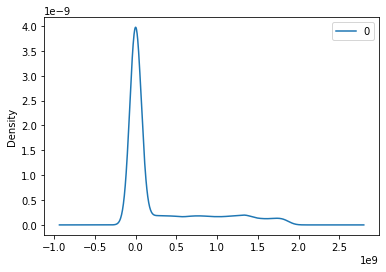

In [56]:
#well at least with a brute force algorithm theres a lot of 0's 
print(distance.min())
pd.DataFrame(distance).plot.kde()
print(distance[1])
print(index[1])
emsc_df.iloc[1]

In [57]:
df.iloc[21862]

1    1.586236e+12
2    3.257750e+01
3    1.320910e+02
4    4.800000e+00
Name: 22628, dtype: float64

In [49]:
# well damn. There aren't any found. I should come back and try alternate algorithms
times = []
for i, dist in enumerate(distance):
    if dist == 0:
        print(df.iloc[index[i-1][0]])
        print(emsc_df.iloc[i-1])
        print()
# this makes me think that I've messed up this code and I'm not matching. 

1    1.586237e+12
2    6.202120e+01
3   -1.484002e+02
4    1.500000e+00
Name: 22627, dtype: float64
1    1.586237e+12
2    3.780000e+01
3    1.691000e+01
4    2.900000e+00
Name: 1, dtype: float64

1    1.586235e+12
2    3.348750e+01
3   -1.164965e+02
4    1.230000e+00
Name: 22619, dtype: float64
1    1.586235e+12
2    3.842000e+01
3    2.588000e+01
4    2.100000e+00
Name: 4, dtype: float64

1    1.586227e+12
2    3.350383e+01
3   -1.165118e+02
4    5.200000e-01
Name: 22589, dtype: float64
1    1.586227e+12
2    3.620000e+01
3   -9.108000e+01
4    2.800000e+00
Name: 20, dtype: float64

1    1.586224e+12
2    3.676000e+01
3   -1.214543e+02
4    7.400000e-01
Name: 22568, dtype: float64
1    1.586224e+12
2    4.450000e+01
3    9.680000e+00
4    2.000000e+00
Name: 29, dtype: float64

1    1.586222e+12
2    3.350367e+01
3   -1.165118e+02
4    1.080000e+00
Name: 22542, dtype: float64
1    1.586222e+12
2    1.916000e+01
3   -1.554500e+02
4    2.100000e+00
Name: 33, dtype: float64

1    1.58621

In [39]:
#check the best match
distance.min()

16578.975510682892

Hang on- I was just realizing that the ID's were included when trying to search for matches, and they souldn't be. That could be throwing off my results.

In [42]:
index

array([[ 618],
       [ 620],
       [ 622],
       ...,
       [4972],
       [4973],
       [4974]])

In [91]:
# attempting to do some lining up by hand
df[df[4]>.4].sort_values(by=4).head(30)

,0,1,2,3,4
7306,7872,1581901023650,33.501333,-116.786333,0.41
18135,18900,1585731600690,33.230167,-116.734167,0.41
21476,22242,1586174055600,33.506667,-116.503500,0.41
20436,21202,1586067639600,33.506167,-116.510333,0.41
3361,3627,1582829274500,35.857333,-117.675500,0.41
1643,1749,1583267723150,37.661167,-118.895167,0.41
3856,4180,1582739615010,37.698500,-118.877000,0.41
16384,17147,1585231111840,35.866667,-117.700833,0.41
3073,3323,1582881115290,38.837666,-122.804169,0.41
202,203,1583661066350,38.832001,-122.802170,0.41


In [79]:
EMSC_df = pd.DataFrame(EMSC_QUAKES)

In [84]:
EMSC_df.sort_values(by=4).head(30)

,0,1,2,3,4
946,947,1585911218000,45.61,15.21,0.4
883,884,1585928095000,45.75,14.05,0.4
839,840,1585940360000,46.09,13.68,0.4
433,434,1586076338500,45.87,15.98,0.5
231,232,1586142907400,45.90,15.98,0.5
780,781,1585966547000,45.95,14.10,0.6
836,837,1585941571000,45.70,14.42,0.6
1286,1287,1585805621100,45.89,15.96,0.6
59,60,1586213070700,47.53,9.27,0.7
599,600,1586019353900,46.64,9.60,0.7


## thought 2, use the history

well nothing so far has produced usable results. I think I'm going to try to line up quakes using the history funciton. 

In [92]:
import requests

In [101]:
requests.get('http://quake-ds-staging.herokuapp.com/history/USGS/0,0,3000').json()

{'message': [{'Oceanic': False,
   'id': 3691,
   'lat': -13.794,
   'lon': -14.6731,
   'mag': 5.3,
   'place': 'Southern Mid-Atlantic Ridge',
   'time': 1582816698668},
  {'Oceanic': False,
   'id': 3697,
   'lat': -13.0278,
   'lon': -15.1094,
   'mag': 4.7,
   'place': 'Southern Mid-Atlantic Ridge',
   'time': 1582816227635},
  {'Oceanic': False,
   'id': 3912,
   'lat': -12.2781,
   'lon': -14.7808,
   'mag': 5.1,
   'place': 'Southern Mid-Atlantic Ridge',
   'time': 1582776671106}],
 'status_code': 200}

In [102]:
requests.get('http://quake-ds-staging.herokuapp.com/history/EMSC/0,0,3000').json()

{'message': [{'id': 8944,
   'lat': -13.79,
   'lon': -14.6,
   'mag': 5.3,
   'place': 'SOUTHERN MID-ATLANTIC RIDGE',
   'time': 1582845498700},
  {'id': 8950,
   'lat': -13.03,
   'lon': -15.11,
   'mag': 4.7,
   'place': 'SOUTHERN MID-ATLANTIC RIDGE',
   'time': 1582845027600},
  {'id': 9057,
   'lat': -12.29,
   'lon': -14.8,
   'mag': 5.1,
   'place': 'SOUTHERN MID-ATLANTIC RIDGE',
   'time': 1582805470900},
  {'id': 19970,
   'lat': -11.75,
   'lon': -13.78,
   'mag': 5.9,
   'place': 'ASCENSION ISLAND REGION',
   'time': 1579271872600},
  {'id': 20219,
   'lat': 0.11,
   'lon': -17.1,
   'mag': 5.5,
   'place': 'NORTH OF ASCENSION ISLAND',
   'time': 1579197498600},
  {'id': 22852,
   'lat': 0.18,
   'lon': -16.93,
   'mag': 5.6,
   'place': 'NORTH OF ASCENSION ISLAND',
   'time': 1578302960400},
  {'id': 23063,
   'lat': -1.2,
   'lon': -12.86,
   'mag': 4.8,
   'place': 'NORTH OF ASCENSION ISLAND',
   'time': 1578160115700},
  {'id': 26206,
   'lat': 1.71,
   'lon': 8.18,
   '

The first three quakes around the area are clearly the same quakes, so there are some in the database, the question is just finding them. 
I'm going to try to algorithmically go through all of the EMSC quakes and search for proximity of time. 

In [ ]:
for quake in EMSC_QUAKES:
    url = f'http://quake-ds-staging.herokuapp.com/history/USGS/{quake[3]},{quake[4]},500'
    responses = requests.get(url).json()['message']
    if len(responses) != 0:
        for response in responses:
            if np.absolute(response['time'] - quake[1]) < 2000:
                print('EMSC:', quake)
                print(response)